In [222]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np

In [233]:
train = pd.read_csv('./data/insurance/train.csv')

In [73]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [199]:
## The classes are highly unbalanced towards the 0-class, i.e. most customers are not interested in vehicle insurance
train[train['Response']==0].shape[0]/train.shape[0]

0.877436638861848

In [246]:
## Preprocessing pipeline which performs a one-hot-encoding for all categorical features and returns a train-test-split
def preprocessing(df):
    processed = df.copy()
    processed['Policy_Sales_Channel'] = processed['Policy_Sales_Channel'].astype('int32').astype('category')
    #processed.drop('Policy_Sales_Channel', axis=1, inplace=True)
    processed['Region_Code'] = processed['Region_Code'].astype('int32').astype('category')
    #processed.drop('Region_Code', axis=1, inplace=True)
    processed = pd.get_dummies(processed,drop_first=True)  ##OneHotEncoding
    X = processed.drop('Response', axis=1)
    y = processed['Response']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test    

In [244]:
## Calculates important metrics to evaluate the performance of a classifier
def eval_clf_perf(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print('accuracy: ', (tn + tp)/(tn+tp+fn+tp))
    print('sensitivity: ', (tp)/(tp+fn))
    print('precision: ', tp/(tp+fp))

In [255]:
## Displays the calibration curve which helps to evaluate how close the predicted class probabilities correspond to actual probabilites
def eval_clf_calib(clf, X_test, y_test):
    probs = clf.predict_proba(X_test)[:,1] #probabilities of class 1
    prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5, strategy='quantile')
    disp = CalibrationDisplay(prob_true, prob_pred, probs)
    disp.plot()

In [247]:
X_train, X_test, y_train, y_test = preprocessing(train)

In [237]:
rf = RandomForestClassifier().fit(X_train, y_train)
eval_clf_perf(rf, X_test, y_test)
eval_clf_calib(rf, X_test, y_test)

In [235]:
lr = LogisticRegression().fit(X_train, y_train)
eval_clf_perf(lr, X_test, y_test)
eval_clf_calib(lr, X_test, y_test)

accuracy:  0.8763523145678278
sensitivity:  0.0014853586080067903
precision:  0.6176470588235294


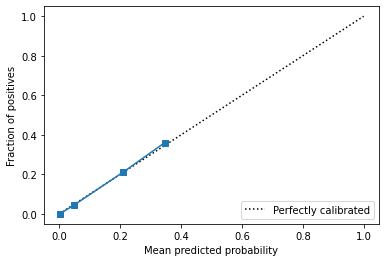

In [259]:
gb = GradientBoostingClassifier(n_estimators=500,learning_rate=0.05).fit(X_train, y_train)
eval_clf_perf(gb, X_test, y_test)
eval_clf_calib(gb, X_test, y_test)

<AxesSubplot:ylabel='Probability'>

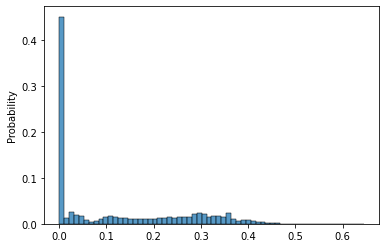

In [258]:
probs = gb.predict_proba(X_test)
sns.histplot(probs[:,1], stat='probability')